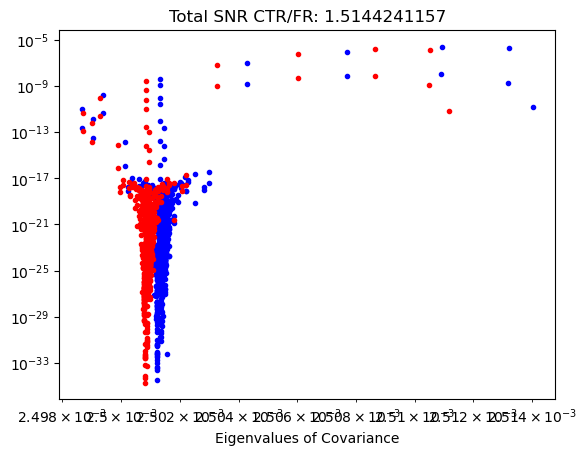

In [121]:
import numpy as np
from matplotlib import pyplot as plt

def get_bump(idir, num_neurons, sigma_input, amplitude):
    center_index_tensor = np.full(num_neurons, int(idir*num_neurons))
    sigma_idx = sigma_input * num_neurons                        # width in *index* units
    d0 = np.arange(0, (num_neurons//2)+1)
    bump_LUT = np.exp(-0.5 * (d0 / sigma_idx)**2)  # size ≈ N/2+1
    distances = np.arange(num_neurons)
    distances = np.abs(distances - center_index_tensor)
    distances = np.minimum(distances, num_neurons - distances)
    input_bump_profile = amplitude* bump_LUT[distances]
    return input_bump_profile

def sigmoid(z):
    # numerically stable sigmoid
    z = np.clip(z, -60, 60)
    return 1.0 / (1.0 + np.exp(-z))

def solve_fixed_point_rho(J, x, beta, g=1.0, R=1.0, damping=0.5,
                          tol=1e-10, max_iters=500000,
                          verbose=False):

    J = np.asarray(J, dtype=float)
    x = np.asarray(x, dtype=float)
    N = x.size
    assert J.shape == (N, N)
    c = beta * g * R


    rho = sigmoid(c * x)

    for it in range(max_iters):
        # fixed-point map
        h = (J @ rho + x)             # "pre-gR" drive
        rho_new = sigmoid(c * h)      # apply nonlinearity
        # damping / mixing for stability
        rho_next = (1.0 - damping) * rho + damping * rho_new
        # convergence check
        err = np.max(np.abs(rho_next - rho))
        rho = rho_next
        if err < tol:
            if verbose:
                print(f"Converged in {it+1} iterations, max|Δrho|={err:.3e}")
            break
    else:
        raise RuntimeError(
            f"Did not converge in {max_iters} iterations. "
            f"Try smaller damping, smaller beta*g*R, or a different init."
        )
    # fixed point drive and D
    h_star = (J @ rho + x)
    D_vec = beta * rho * (1.0 - rho)          # D_ii entries
    D_mat = np.diag(D_vec)

    return D_mat

def calculate_R(N, T,ampar,rin):
    # Generate J
    indices = np.arange(N)
    i_matrix = indices[:, None]      # shape (N, 1)
    j_matrix = indices[None, :]      # shape (1, N)
    diff = np.abs(i_matrix - j_matrix)
    diff = np.minimum(diff, N - diff)
    threshold = THRESHOLD_ACTIVE_FUNCTION * N / 2.0
    weights = (diff <= threshold).astype(float) / N
    np.fill_diagonal(weights, 0.0)
    D_matrix = solve_fixed_point_rho(weights, get_bump(0.5, N, SIG_INPUT, AMPLITUDE,), g = ampar, R = rin, beta=T)
    R_matrix= np.linalg.inv(np.eye(N) - rin*ampar*D_matrix @ weights) @ (D_matrix*rin)
    return R_matrix

N = 1000
SIG_INPUT = 0.1
AMPLITUDE = 0.1
THRESHOLD_ACTIVE_FUNCTION = 0.2
TEMP = 0.1
SIGMA_GAMMA = 0.05

AMPAR_CTR = 1.0
RIN_CTR = 1.0   
AMPAR_FR = 0.64
RIN_FR = 1.27

CROSSOVER_EVAL_CTR = TEMP/(RIN_CTR*(SIGMA_GAMMA*AMPAR_CTR)**2)
CROSSOVER_EVAL_FR = TEMP/(RIN_FR*(SIGMA_GAMMA*AMPAR_FR)**2)

# Not Sure the Calculation of D is correct, right now its just the input bump and not average activity

R_matrix_CTR = calculate_R( N=N, T=TEMP, ampar=AMPAR_CTR, rin=RIN_CTR)

R_matrix_FR = calculate_R( N=N, T=TEMP, ampar=AMPAR_FR, rin=RIN_FR)
covariance_CTR = R_matrix_CTR @ R_matrix_CTR.T*(SIGMA_GAMMA*AMPAR_CTR)**2+ TEMP*R_matrix_CTR/RIN_CTR
covariance_FR = R_matrix_FR @ R_matrix_FR.T*(SIGMA_GAMMA*AMPAR_FR)**2+ TEMP*R_matrix_FR/RIN_FR

D_THETA = 0.01
D_X = get_bump(0.5 + D_THETA, N, SIG_INPUT, AMPLITUDE) - get_bump(0.5, N, SIG_INPUT, AMPLITUDE)
eval_ctr,evec_ctr = np.linalg.eigh(covariance_CTR)
eval_fr,evec_fr = np.linalg.eigh(covariance_FR)
overlap_ctr = np.dot(evec_ctr.T, AMPAR_CTR* R_matrix_CTR@D_X)**2
overlap_fr = np.dot(evec_fr.T, AMPAR_FR* R_matrix_FR@D_X)**2
plt.plot(eval_ctr, overlap_ctr, '.', label='CTR', color='blue')
plt.plot(eval_fr, overlap_fr, '.', label='FR', color='red')
# plt.axvline(CROSSOVER_EVAL_CTR, color='blue', linestyle='--')
# plt.axvline(CROSSOVER_EVAL_FR, color='red', linestyle='--')
plt.title(f'Total SNR CTR/FR: {np.sum(overlap_ctr/eval_ctr)/np.sum(overlap_fr/eval_fr):.10f}')
plt.xlabel('Eigenvalues of Covariance')
plt.xscale('log')
plt.yscale('log')

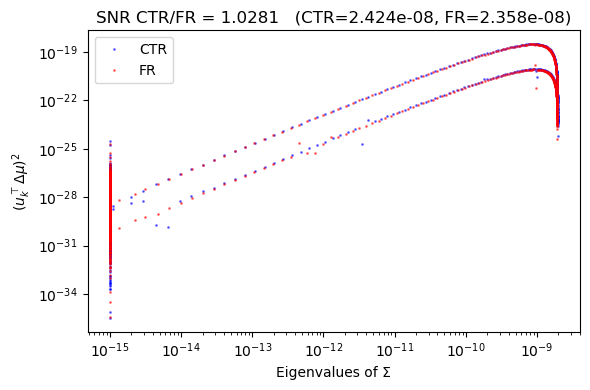

In [141]:
import numpy as np
from matplotlib import pyplot as plt

# ----------------------------
# Utilities
# ----------------------------
def get_bump(idir, num_neurons, sigma_input, amplitude):
    center = int(idir * num_neurons) % num_neurons
    sigma_idx = sigma_input * num_neurons
    d = np.arange(num_neurons)
    d = np.abs(d - center)
    d = np.minimum(d, num_neurons - d)
    return amplitude * np.exp(-0.5 * (d / sigma_idx) ** 2)

def sigmoid(z):
    z = np.clip(z, -60, 60)
    return 1.0 / (1.0 + np.exp(-z))

def make_ring_boxcar_J(N, width_frac, scale=1.0):
    """Symmetric ring connectivity: boxcar within distance threshold, normalized by N."""
    idx = np.arange(N)
    diff = np.abs(idx[:, None] - idx[None, :])
    diff = np.minimum(diff, N - diff)
    thr = width_frac * N / 2.0
    J = (diff <= thr).astype(float) / N
    np.fill_diagonal(J, 0.0)
    return scale * J

# ----------------------------
# Mean-field fixed point:
# rho = sigma(beta * g*R * (J rho + x))
# ----------------------------
def solve_fixed_point_rho(J, x, beta, g=1.0, R=1.0,
                          damping=0.05, tol=1e-10, max_iters=200_000,
                          verbose=False):
    """
    Deterministic mean-field fixed point:
        rho = sigmoid( beta * g*R * (J @ rho + x) )
    """
    J = np.asarray(J, float)
    x = np.asarray(x, float)
    N = x.size
    assert J.shape == (N, N)

    c = beta * g * R

    # init: response to feedforward bump only
    rho = sigmoid(c * x)
    rho = np.clip(rho, 1e-9, 1 - 1e-9)

    for it in range(max_iters):
        h = (J @ rho + x)
        rho_new = sigmoid(c * h)
        rho_next = (1.0 - damping) * rho + damping * rho_new
        err = np.max(np.abs(rho_next - rho))
        rho = rho_next
        if err < tol:
            if verbose:
                print(f"Converged in {it+1} iters, max|Δrho|={err:.3e}")
            break
    else:
        raise RuntimeError("Fixed point did not converge; reduce beta or J scale, or reduce damping.")

    return rho

# ----------------------------
# Symmetric linear response:
# Gamma = r * D^{1/2} (I - r*w D^{1/2} J D^{1/2})^{-1} D^{1/2}
# where D_ii = beta * rho_i (1-rho_i)
# ----------------------------
def compute_Gamma_symmetric(J, rho_star, beta, w, r):
    D_vec = beta * rho_star * (1.0 - rho_star)  # D_ii
    D_sqrt = np.sqrt(np.clip(D_vec, 1e-15, None))
    # Build symmetric "effective" coupling
    JD = (D_sqrt[:, None] * J) * D_sqrt[None, :]   # D^{1/2} J D^{1/2}
    A = np.eye(J.shape[0]) - (r * w) * JD
    # Solve A X = D^{1/2}
    X = np.linalg.solve(A, np.diag(D_sqrt))
    Gamma = r * (np.diag(D_sqrt) @ X)  # r * D^{1/2} A^{-1} D^{1/2}
    # Symmetrize to remove tiny numerical asymmetry
    Gamma = 0.5 * (Gamma + Gamma.T)
    return Gamma, D_vec

# ----------------------------
# Full pipeline for a condition (w,r)
# ----------------------------
def compute_condition(N, TEMP, sigma_gamma, w, r,
                      sigma_input, amplitude, width_frac, J_scale=1.0,
                      idir0=0.5, verbose=False):
    """
    TEMP plays the role of Ising temperature T, so beta = 1/TEMP.
    """
    beta = 1.0 / TEMP
    J = make_ring_boxcar_J(N, width_frac=width_frac, scale=J_scale)
    x0 = get_bump(idir0, N, sigma_input, amplitude)

    rho_star = solve_fixed_point_rho(J, x0, beta=beta, g=w, R=r, damping=0.05, tol=1e-10, verbose=verbose)
    Gamma, D_vec = compute_Gamma_symmetric(J, rho_star, beta=beta, w=w, r=r)

    # Total covariance: slow + fast
    Sigma_slow = (w * sigma_gamma) ** 2 * (Gamma @ Gamma.T)
    Sigma_fast = (TEMP / r) * Gamma
    Sigma = Sigma_slow + Sigma_fast
    Sigma = 0.5 * (Sigma + Sigma.T)

    return J, x0, rho_star, D_vec, Gamma, Sigma

# ----------------------------
# Parameters
# ----------------------------
N = 1000
SIG_INPUT = 0.1
AMPLITUDE = 0.1
WIDTH_FRAC = 0.2
J_SCALE = 1.0

TEMP = 0.0001          # This is T (so beta = 1/T)
SIGMA_GAMMA = 0.4

AMPAR_CTR, RIN_CTR = 1.0, 1.0
AMPAR_FR,  RIN_FR  = 0.64, 1.27

# ----------------------------
# Compute two conditions
# ----------------------------
J, x0, rho_ctr, D_ctr, Gamma_ctr, Sigma_ctr = compute_condition(
    N, TEMP, SIGMA_GAMMA, w=AMPAR_CTR, r=RIN_CTR,
    sigma_input=SIG_INPUT, amplitude=AMPLITUDE, width_frac=WIDTH_FRAC, J_scale=J_SCALE,
    verbose=False
)

_, _, rho_fr, D_fr, Gamma_fr, Sigma_fr = compute_condition(
    N, TEMP, SIGMA_GAMMA, w=AMPAR_FR, r=RIN_FR,
    sigma_input=SIG_INPUT, amplitude=AMPLITUDE, width_frac=WIDTH_FRAC, J_scale=J_SCALE,
    verbose=False
)

# ----------------------------
# Build Δx for a chosen Δθ
# ----------------------------
D_THETA = 0.01
Dx = get_bump(0.5 + D_THETA, N, SIG_INPUT, AMPLITUDE) - get_bump(0.5, N, SIG_INPUT, AMPLITUDE)

# Signal Δμ = w * Gamma * Δx
dmu_ctr = AMPAR_CTR * (Gamma_ctr @ Dx)
dmu_fr  = AMPAR_FR  * (Gamma_fr  @ Dx)

# ----------------------------
# Eigendecompose Σ and compute per-mode overlaps and SNR
# ----------------------------
eval_ctr, evec_ctr = np.linalg.eigh(Sigma_ctr)
eval_fr,  evec_fr  = np.linalg.eigh(Sigma_fr)

# projection of signal onto Σ-eigenmodes
proj_ctr = (evec_ctr.T @ dmu_ctr)
proj_fr  = (evec_fr.T  @ dmu_fr)

overlap_ctr = proj_ctr**2
overlap_fr  = proj_fr**2

snr_ctr = np.sum(overlap_ctr / np.clip(eval_ctr, 1e-15, None))
snr_fr  = np.sum(overlap_fr  / np.clip(eval_fr,  1e-15, None))

# ----------------------------
# Plot: eigenvalue vs overlap (mode contributions)
# ----------------------------
plt.figure(figsize=(6,4))
plt.plot(eval_ctr, overlap_ctr, '.', label='CTR', color='blue', alpha=0.5, markersize=2)
plt.plot(eval_fr,  overlap_fr,  '.', label='FR',  color='red',  alpha=0.5, markersize=2)
plt.title(f"SNR CTR/FR = {snr_ctr/snr_fr:.4f}   (CTR={snr_ctr:.3e}, FR={snr_fr:.3e})")
plt.xlabel("Eigenvalues of Σ")
plt.ylabel(r"$(u_k^\top \Delta\mu)^2$")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()


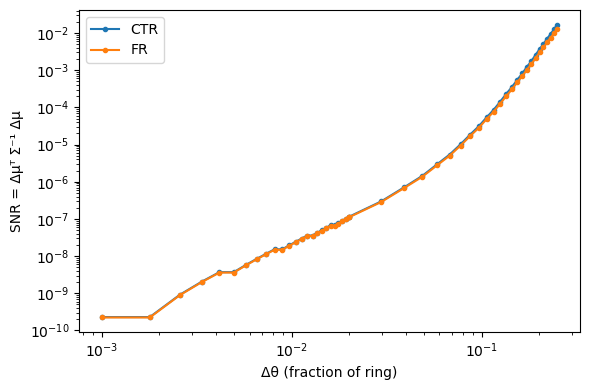

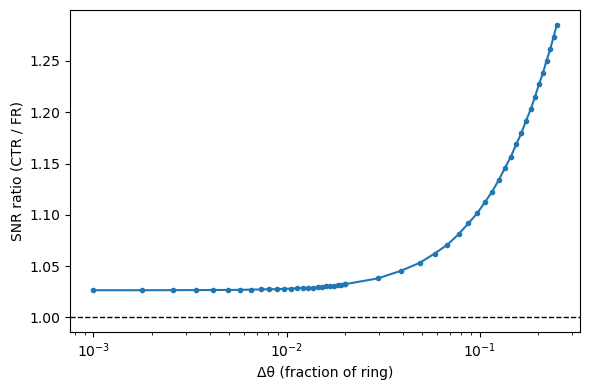

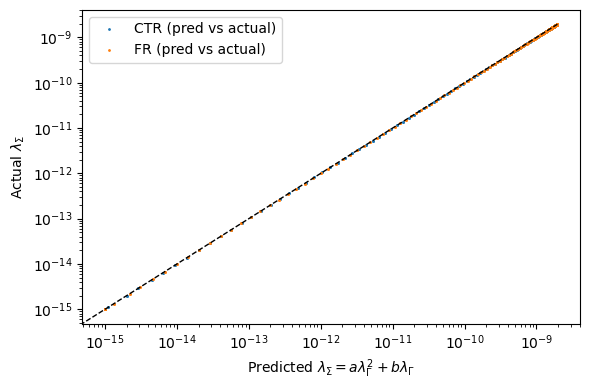

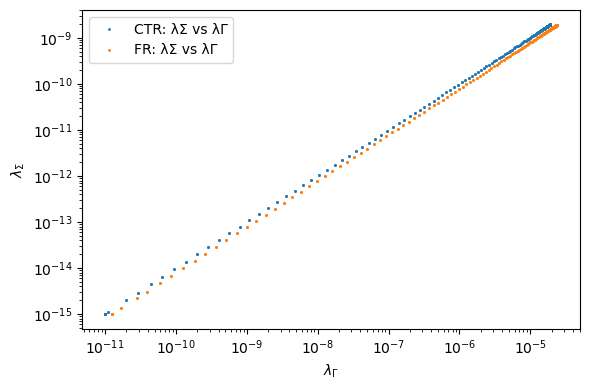

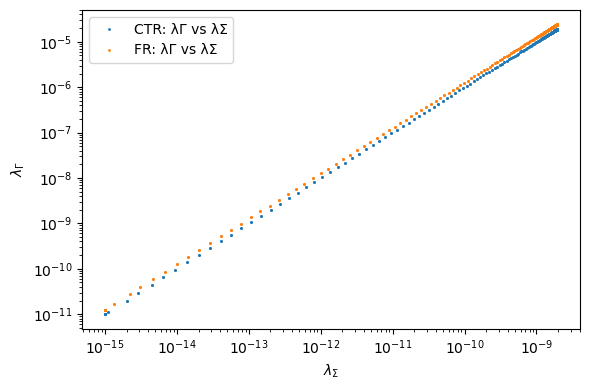

In [143]:
# ----------------------------
# Diagnostic: λΣ vs λΓ scaling
# ----------------------------
# Since Sigma = a Γ^2 + b Γ and Γ is symmetric, Γ and Σ share eigenvectors.
# So compare eigenvalues directly.

lamG_ctr = np.linalg.eigvalsh(Gamma_ctr)
lamG_fr  = np.linalg.eigvalsh(Gamma_fr)

a_ctr = (AMPAR_CTR * SIGMA_GAMMA)**2
b_ctr = TEMP / RIN_CTR
pred_ctr = a_ctr * lamG_ctr**2 + b_ctr * lamG_ctr

a_fr = (AMPAR_FR * SIGMA_GAMMA)**2
b_fr = TEMP / RIN_FR
pred_fr = a_fr * lamG_fr**2 + b_fr * lamG_fr

# Actual Σ eigenvalues are eval_ctr/eval_fr from before
plt.figure(figsize=(6,4))
plt.plot(pred_ctr, eval_ctr, '.', markersize=2, label='CTR (pred vs actual)')
plt.plot(pred_fr,  eval_fr,  '.', markersize=2, label='FR (pred vs actual)')
mx = max(pred_ctr.max(), pred_fr.max(), eval_ctr.max(), eval_fr.max())
plt.plot([0, mx], [0, mx], 'k--', lw=1)
plt.xlabel(r'Predicted $\lambda_\Sigma = a\lambda_\Gamma^2 + b\lambda_\Gamma$')
plt.ylabel(r'Actual $\lambda_\Sigma$')
plt.xscale('log'); plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

# Now show the regimes by plotting λΣ vs λΓ on log-log
plt.figure(figsize=(6,4))
plt.plot(lamG_ctr, eval_ctr, '.', markersize=2, label='CTR: λΣ vs λΓ')
plt.plot(lamG_fr,  eval_fr,  '.', markersize=2, label='FR: λΣ vs λΓ')
plt.xlabel(r'$\lambda_\Gamma$')
plt.ylabel(r'$\lambda_\Sigma$')
plt.xscale('log'); plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

# If you want the sqrt behavior, plot λΓ vs λΣ:
plt.figure(figsize=(6,4))
plt.plot(eval_ctr, lamG_ctr, '.', markersize=2, label='CTR: λΓ vs λΣ')
plt.plot(eval_fr,  lamG_fr,  '.', markersize=2, label='FR: λΓ vs λΣ')
plt.xlabel(r'$\lambda_\Sigma$')
plt.ylabel(r'$\lambda_\Gamma$')
plt.xscale('log'); plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()


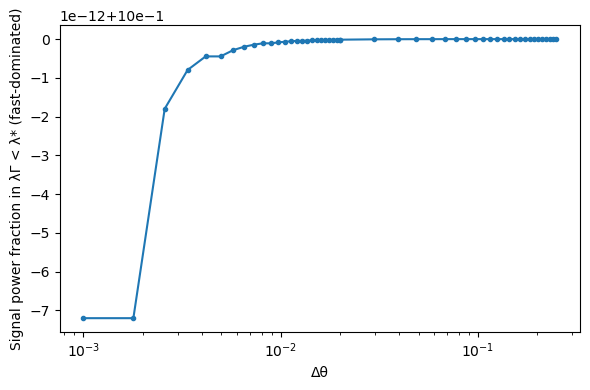

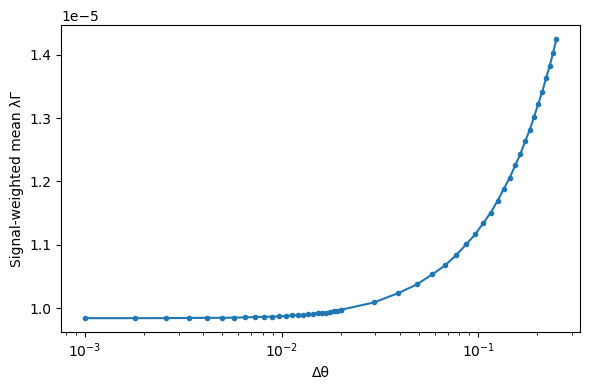

λ* = 0.0006249999999999999 min/max λΓ: 9.992007212043494e-12 1.8953211187302736e-05


In [144]:
# Diagnostic: does Δθ move signal power across the Γ crossover?
lamG, vecG = np.linalg.eigh(Gamma_ctr)

a = (AMPAR_CTR * SIGMA_GAMMA)**2
b = TEMP / RIN_CTR
lam_star = b / a  # crossover in λΓ

thetas = np.concatenate([np.linspace(0.001, 0.02, 25),
                         np.linspace(0.02, 0.25, 25)])

frac_low = []
mean_lam = []

for dtheta in thetas:
    Dx = get_bump(0.5 + dtheta, N, SIG_INPUT, AMPLITUDE) - get_bump(0.5, N, SIG_INPUT, AMPLITUDE)
    dmu = AMPAR_CTR * (Gamma_ctr @ Dx)

    coeff = vecG.T @ dmu
    power = coeff**2
    power /= power.sum() + 1e-30

    frac_low.append(power[lamG < lam_star].sum())
    mean_lam.append((power * lamG).sum())

plt.figure(figsize=(6,4))
plt.plot(thetas, frac_low, '-o', markersize=3)
plt.xscale('log')
plt.xlabel('Δθ')
plt.ylabel('Signal power fraction in λΓ < λ* (fast-dominated)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(thetas, mean_lam, '-o', markersize=3)
plt.xscale('log')
plt.xlabel('Δθ')
plt.ylabel('Signal-weighted mean λΓ')
plt.tight_layout()
plt.show()

print("λ* =", lam_star, "min/max λΓ:", lamG.min(), lamG.max())


[CTR] λ* = 6.250e-04
[CTR] λΓ range: min=9.992e-12, max=1.895e-05
[CTR] fraction of modes with λΓ < λ*: 1.000


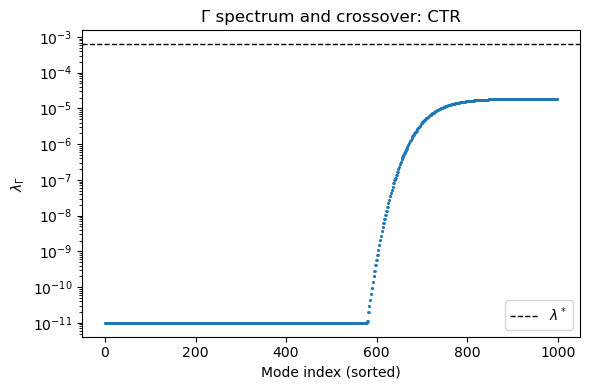

[FR] λ* = 1.201e-03
[FR] λΓ range: min=1.269e-11, max=2.408e-05
[FR] fraction of modes with λΓ < λ*: 1.000


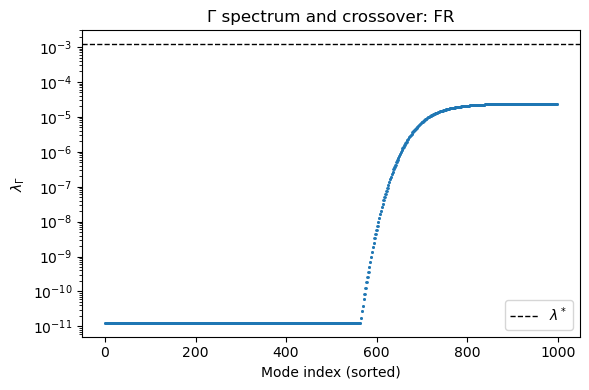

In [ ]:



import numpy as np
import matplotlib.pyplot as plt




def lambda_star(T, r, w, sigma_gamma):
    # λ* in the Γ-eigenvalue domain: compare bλ vs aλ^2 with a=(wσγ)^2, b=T/r
    return (T / r) / ((w * sigma_gamma) ** 2)

def plot_crossover_placement(Gamma, T, r, w, sigma_gamma, label):
    # Ensure symmetry (numerical)
    G = 0.5 * (Gamma + Gamma.T)
    lamG = np.linalg.eigvalsh(G)
    lamG = np.sort(lamG)

    lam_star = lambda_star(T, r, w, sigma_gamma)

    print(f"[{label}] λ* = {lam_star:.3e}")
    print(f"[{label}] λΓ range: min={lamG[0]:.3e}, max={lamG[-1]:.3e}")
    print(f"[{label}] fraction of modes with λΓ < λ*: {(lamG < lam_star).mean():.3f}")

    plt.figure(figsize=(6,4))
    plt.plot(lamG, '.', markersize=2)
    plt.axhline(lam_star, color='k', linestyle='--', lw=1, label=r'$\lambda^*$')
    plt.yscale('log')
    plt.xlabel('Mode index (sorted)')
    plt.ylabel(r'$\lambda_\Gamma$')
    plt.title(f'Γ spectrum and crossover: {label}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return lamG, lam_star

# --- run for CTR + FR ---
lamG_ctr, lam_star_ctr = plot_crossover_placement(
    Gamma_ctr, T=TEMP, r=RIN_CTR, w=AMPAR_CTR, sigma_gamma=SIGMA_GAMMA, label="CTR"
)
lamG_fr, lam_star_fr = plot_crossover_placement(
    Gamma_fr,  T=TEMP, r=RIN_FR,  w=AMPAR_FR,  sigma_gamma=SIGMA_GAMMA, label="FR"
)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def signal_power_fraction_fast(Gamma, w, r, T, sigma_gamma, thetas, idir0=0.5):
    # Diagonalize Γ (symmetric)
    G = 0.5 * (Gamma + Gamma.T)
    lamG, vecG = np.linalg.eigh(G)
    lam_star = lambda_star(T, r, w, sigma_gamma)

    frac_fast = []
    mean_lam = []

    for dtheta in thetas:
        Dx = get_bump(idir0 + dtheta, N, SIG_INPUT, AMPLITUDE) - get_bump(idir0, N, SIG_INPUT, AMPLITUDE)

        # Use Δμ = w Γ Δx (this is the signal that enters SNR)
        dmu = w * (G @ Dx)

        coeff = vecG.T @ dmu
        power = coeff**2
        power = power / (power.sum() + 1e-30)

        frac_fast.append(power[lamG < lam_star].sum())
        mean_lam.append((power * lamG).sum())

    return np.array(frac_fast), np.array(mean_lam), lam_star, lamG

# Δθ grid
thetas = np.concatenate([
    np.linspace(0.001, 0.02, 25),
    np.linspace(0.02, 0.25, 25)
])

frac_fast_ctr, mean_lam_ctr, lam_star_ctr, _ = signal_power_fraction_fast(
    Gamma_ctr, w=AMPAR_CTR, r=RIN_CTR, T=TEMP, sigma_gamma=SIGMA_GAMMA, thetas=thetas
)
frac_fast_fr, mean_lam_fr, lam_star_fr, _ = signal_power_fraction_fast(
    Gamma_fr,  w=AMPAR_FR,  r=RIN_FR,  T=TEMP, sigma_gamma=SIGMA_GAMMA, thetas=thetas
)

plt.figure(figsize=(6,4))
plt.plot(thetas, frac_fast_ctr, '-o', markersize=3, label='CTR')
plt.plot(thetas, frac_fast_fr,  '-o', markersize=3, label='FR')
plt.xscale('log')
plt.ylim(0, 1)
plt.xlabel('Δθ (fraction of ring)')
plt.ylabel(r'Fraction of signal power in modes with $\lambda_\Gamma < \lambda^*$')
plt.title('Does Δθ push signal into fast-dominated modes?')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(thetas, mean_lam_ctr, '-o', markersize=3, label='CTR')
plt.plot(thetas, mean_lam_fr,  '-o', markersize=3, label='FR')
plt.xscale('log')
plt.xlabel('Δθ (fraction of ring)')
plt.ylabel(r'Signal-weighted mean $\lambda_\Gamma$')
plt.title('Signal-weighted mean λΓ vs Δθ')
plt.legend()
plt.tight_layout()
plt.show()

print(f"CTR λ*={lam_star_ctr:.3e} | FR λ*={lam_star_fr:.3e}")


In [ ]:


# def snr_calc(Delta_theta, COV, RMAT):
#     Delta_x = get_bump(0.5 + Delta_theta, N, SIG_INPUT, AMPLITUDE) - get_bump(0.5, N, SIG_INPUT, AMPLITUDE)
#     DMU = RMAT @ Delta_x 
#     Delta_mu_FR = AMPAR_FR * R_matrix_FR @ Delta_x

#     SNR = DMU @ np.linalg.inv(COV) @ DMU
#     return SNR

# DTHETA = np.arange(0.0001, 0.5, 0.01)
# plt.plot(DTHETA,[snr_calc(dtheta, covariance_CTR, AMPAR_CTR* R_matrix_CTR) for dtheta in DTHETA], label='CTR', color = 'blue')
# plt.plot(DTHETA,[snr_calc(dtheta, covariance_FR, AMPAR_FR* R_matrix_FR) for dtheta in DTHETA], label='FR', color = 'red')
# plt.xlabel('Delta Theta (fraction of 2pi)')
# plt.ylabel('SNR')
# plt.legend()


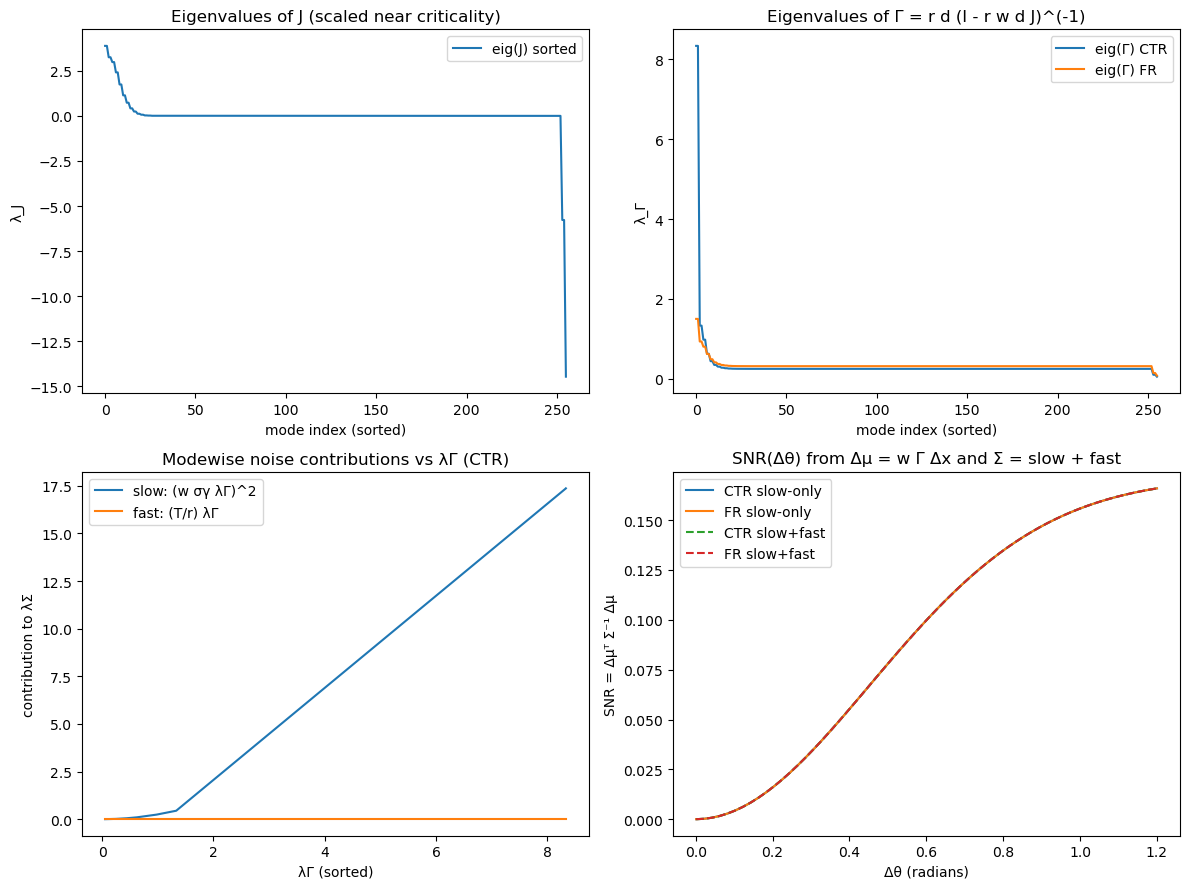

==== Parameter summary ====
N=256, d=0.25, gain_target (CTR)=0.97
CTR: w=1.0, r=1.0
FR : w=0.64, r=1.27
sigma_gamma=0.5, T_fast=0.0, sigma_eta_private=0.0, kappa=10.0
Tip: Increase gain_target toward 0.99 to increase λΓ spread and enhance slow-vs-fast crossover.
Tip: Increase sigma_gamma (slow) or decrease T_fast (fast) to move toward slow-dominated regime.


In [127]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Build a toy ring CANN J
# -----------------------------
def wrap_to_pi(x):
    return (x + np.pi) % (2*np.pi) - np.pi

def build_mexican_hat_J(theta, J_exc=1.0, sig_exc=0.25, J_inh=0.8, sig_inh=1.0, scale_to_max_eig=0.9):
    """
    Mexican-hat on a ring (symmetric, dense), scaled so max eigenvalue ~ scale_to_max_eig.
    """
    N = theta.size
    dtheta = wrap_to_pi(theta[:, None] - theta[None, :])

    # difference-of-Gaussians kernel on the ring
    K = J_exc * np.exp(-(dtheta**2) / (2*sig_exc**2)) - J_inh * np.exp(-(dtheta**2) / (2*sig_inh**2))
    J = K / N  # 1/N scaling

    # scale so that max eigenvalue of J is exactly scale_to_max_eig
    evals, _ = np.linalg.eigh(J)
    lam_max = evals.max()
    J *= (scale_to_max_eig / lam_max)
    return J

# -----------------------------
# 2) Linear response Γ from J eigenpairs
# -----------------------------
def gamma_eigs_from_J_eigs(lam_J, w, r, d):
    """
    If J is symmetric and D=d*I (constant slope), then J and Γ share eigenvectors.
    Γ eigenvalues: λΓ = r d / (1 - r w d λJ)
    """
    denom = 1.0 - (r*w*d)*lam_J
    if np.any(np.isclose(denom, 0.0)):
        raise ValueError("Unstable: 1 - r*w*d*λJ hits 0. Reduce gain or scale J down.")
    return (r*d) / denom

# -----------------------------
# 3) Stimulus bumps and Δx projections
# -----------------------------
def von_mises_bump(theta, center, kappa=8.0):
    x = np.exp(kappa*np.cos(theta - center))
    x /= x.sum()  # normalize area
    return x

def delta_x(theta, dtheta, kappa=8.0):
    x1 = von_mises_bump(theta, 0.0, kappa=kappa)
    x2 = von_mises_bump(theta, dtheta, kappa=kappa)
    dx = x1 - x2
    # remove DC component (often irrelevant in activity-conserving / bump codes)
    dx -= dx.mean()
    return dx

# -----------------------------
# 4) Covariance model and SNR (in Γ eigenbasis)
# -----------------------------
def snr_curve(theta, evecs, lam_G, w, r, sigma_gamma, T_fast,
              sigma_eta_private=0.0,  # private fast noise not mediated by AMPAR, adds (r*sigma_eta)^2 I
              kappa=8.0, dtheta_grid=None, ridge=1e-10):
    """
    Σ = (w*sigma_gamma)^2 ΓΓ^T + (T_fast/r)*Γ + (r*sigma_eta)^2 I
    Δμ = w Γ Δx

    Because Σ is a polynomial in Γ plus I, Σ and Γ share eigenvectors (J symmetric, D constant).
    So SNR = sum_k (Δμ_k^2 / λΣ_k)
    """
    if dtheta_grid is None:
        dtheta_grid = np.linspace(1e-3, np.pi, 60)

    # eigenvalues of Σ in Γ basis
    lam_slow = (w * sigma_gamma * lam_G)**2
    lam_fast_thermal = (T_fast / r) * lam_G
    lam_fast_private = (r * sigma_eta_private)**2  # isotropic across modes
    lam_S = lam_slow + lam_fast_thermal + lam_fast_private + ridge

    snr = np.zeros_like(dtheta_grid)
    for i, dth in enumerate(dtheta_grid):
        dx = delta_x(theta, dth, kappa=kappa)
        # project Δx into Γ/J eigenbasis
        dx_k = evecs.T @ dx
        dmu_k = w * lam_G * dx_k
        snr[i] = np.sum((dmu_k**2) / lam_S)
    return dtheta_grid, snr, lam_slow, lam_fast_thermal, lam_fast_private

# -----------------------------
# 5) Run a "dummy case"
# -----------------------------
def main():
    # Ring grid
    N = 256
    theta = np.linspace(0, 2*np.pi, N, endpoint=False)

    # Build J
    J = build_mexican_hat_J(
        theta,
        J_exc=1.0, sig_exc=0.25,
        J_inh=0.85, sig_inh=1.1,
        scale_to_max_eig=1.0  # we will control proximity-to-criticality via gain below
    )
    lam_J, evecs = np.linalg.eigh(J)  # symmetric

    # Choose a constant sigmoid slope D=d*I (dummy operating point)
    d = 0.25  # max slope of logistic is 0.25 at 0

    # Define CTR vs FR parameters (dummy)
    # CTR:
    w_ctr, r_ctr = 1.0, 1.0
    # FR:
    w_fr, r_fr = 0.64, 1.27  # your typical values

    # Choose overall gain-to-criticality by scaling J further so that max (r*w*d*λJ) is close to 1
    # This controls how large Γ eigenvalues can get (and whether slow-vs-fast crossover appears).
    # We scale J so that for CTR: (r*w*d*maxλJ) = gain_target
    gain_target = 0.97
    lamJ_max = lam_J.max()
    scale_extra = gain_target / (r_ctr*w_ctr*d*lamJ_max)
    J2 = J * scale_extra
    lam_J2, evecs2 = np.linalg.eigh(J2)

    # Compute Γ eigenvalues
    lam_G_ctr = gamma_eigs_from_J_eigs(lam_J2, w_ctr, r_ctr, d)
    lam_G_fr  = gamma_eigs_from_J_eigs(lam_J2, w_fr,  r_fr,  d)

    # Noise parameters
    sigma_gamma = 0.5   # slow noise amplitude (dummy)
    T_fast = 0.00      # fast/thermal-like coefficient (dummy)
    sigma_eta = 0.00     # optional private fast noise (set >0 to see additional symmetry breaking)

    # Stimulus width and angle grid
    kappa = 10.0
    dtheta_grid = np.linspace(1e-3, 1.2, 60)  # focus on "small vs moderate angles" in radians

    # SNR curves: slow-only and slow+fast
    dth, snr_ctr_slow, *_ = snr_curve(theta, evecs2, lam_G_ctr, w_ctr, r_ctr,
                                      sigma_gamma=sigma_gamma, T_fast=0.0,
                                      sigma_eta_private=0.0, kappa=kappa, dtheta_grid=dtheta_grid)
    _,   snr_fr_slow,  *_ = snr_curve(theta, evecs2, lam_G_fr,  w_fr,  r_fr,
                                      sigma_gamma=sigma_gamma, T_fast=0.0,
                                      sigma_eta_private=0.0, kappa=kappa, dtheta_grid=dtheta_grid)

    dth, snr_ctr_full, lam_slow_ctr, lam_fast_ctr, lam_priv_ctr = snr_curve(
        theta, evecs2, lam_G_ctr, w_ctr, r_ctr,
        sigma_gamma=sigma_gamma, T_fast=T_fast,
        sigma_eta_private=sigma_eta, kappa=kappa, dtheta_grid=dtheta_grid
    )
    _,   snr_fr_full,  lam_slow_fr,  lam_fast_fr,  lam_priv_fr  = snr_curve(
        theta, evecs2, lam_G_fr, w_fr, r_fr,
        sigma_gamma=sigma_gamma, T_fast=T_fast,
        sigma_eta_private=sigma_eta, kappa=kappa, dtheta_grid=dtheta_grid
    )

    # -----------------------------
    # 6) Plots
    # -----------------------------
    fig = plt.figure(figsize=(12, 9))

    # (A) Eigenvalues: J and Γ
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.plot(np.sort(lam_J2)[::-1], label="eig(J) sorted")
    ax1.set_title("Eigenvalues of J (scaled near criticality)")
    ax1.set_xlabel("mode index (sorted)")
    ax1.set_ylabel("λ_J")
    ax1.legend()

    ax2 = fig.add_subplot(2, 2, 2)
    ax2.plot(np.sort(lam_G_ctr)[::-1], label="eig(Γ) CTR")
    ax2.plot(np.sort(lam_G_fr)[::-1],  label="eig(Γ) FR")
    ax2.set_title("Eigenvalues of Γ = r d (I - r w d J)^(-1)")
    ax2.set_xlabel("mode index (sorted)")
    ax2.set_ylabel("λ_Γ")
    ax2.legend()

    # (B) Show how λΣ depends on λΓ (linear vs quadratic parts)
    ax3 = fig.add_subplot(2, 2, 3)
    # pick CTR to show decomposition
    lamG_sorted = np.sort(lam_G_ctr)[::-1]
    slow_sorted = (w_ctr*sigma_gamma*lamG_sorted)**2
    fast_sorted = (T_fast/r_ctr)*lamG_sorted
    ax3.plot(lamG_sorted, slow_sorted, label="slow: (w σγ λΓ)^2")
    ax3.plot(lamG_sorted, fast_sorted, label="fast: (T/r) λΓ")
    ax3.set_title("Modewise noise contributions vs λΓ (CTR)")
    ax3.set_xlabel("λΓ (sorted)")
    ax3.set_ylabel("contribution to λΣ")
    ax3.legend()

    # (C) SNR vs Δθ: slow-only vs slow+fast (CTR vs FR)
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.plot(dth, snr_ctr_slow, label="CTR slow-only")
    ax4.plot(dth, snr_fr_slow,  label="FR slow-only")
    ax4.plot(dth, snr_ctr_full, linestyle="--", label="CTR slow+fast")
    ax4.plot(dth, snr_fr_full,  linestyle="--", label="FR slow+fast")
    ax4.set_title("SNR(Δθ) from Δμ = w Γ Δx and Σ = slow + fast")
    ax4.set_xlabel("Δθ (radians)")
    ax4.set_ylabel("SNR = Δμᵀ Σ⁻¹ Δμ")
    ax4.legend()

    fig.tight_layout()
    plt.show()

    # -----------------------------
    # 7) Notes printed to help tuning
    # -----------------------------
    print("==== Parameter summary ====")
    print(f"N={N}, d={d}, gain_target (CTR)={gain_target}")
    print(f"CTR: w={w_ctr}, r={r_ctr}")
    print(f"FR : w={w_fr}, r={r_fr}")
    print(f"sigma_gamma={sigma_gamma}, T_fast={T_fast}, sigma_eta_private={sigma_eta}, kappa={kappa}")
    print("Tip: Increase gain_target toward 0.99 to increase λΓ spread and enhance slow-vs-fast crossover.")
    print("Tip: Increase sigma_gamma (slow) or decrease T_fast (fast) to move toward slow-dominated regime.")

if __name__ == "__main__":
    main()


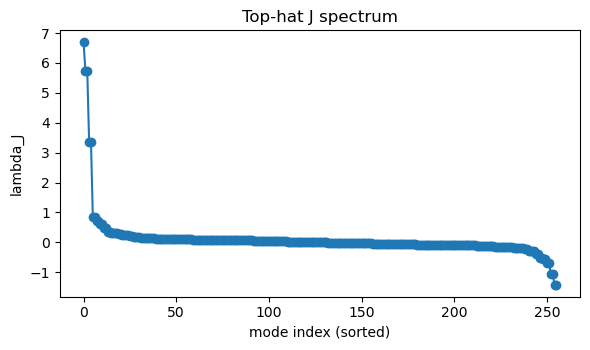

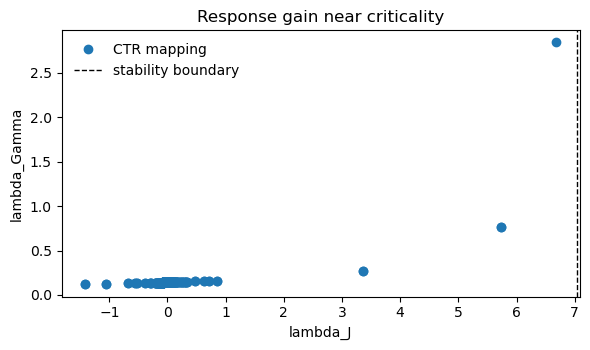

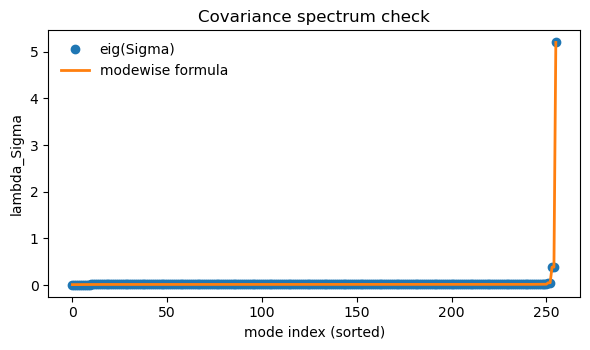

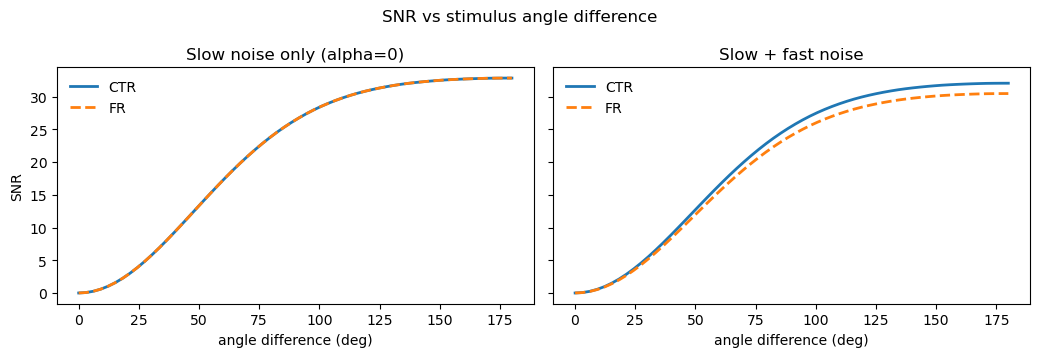

==== Parameter summary ====
N=256, top_hat_width=0.942 rad, j_height=1.0, gain_target=0.95
rho_mean=0.172, d=0.142, J_scale=22.229
CTR: w=1.0, r=1.0; FR: w=0.64, r=1.27
sigma_gamma=0.8, alpha=0.01, normalize_delta_x=False
Metrics: slow-only gap=0.000, fast small-angle advantage=0.065, fast large-angle gap=0.052


In [22]:
#!/usr/bin/env python3
"""Toy spectral model: top-hat CANN J, bump-derived D, and SNR.

Only numpy + matplotlib. No time-series simulation.
"""

import numpy as np
import matplotlib.pyplot as plt


def wrap_to_pi(x):
    return (x + np.pi) % (2.0 * np.pi) - np.pi


def build_top_hat_j(theta, width, height):
    """Top-hat connectivity on a ring with 1/N scaling."""
    n = theta.size
    dtheta = wrap_to_pi(theta[:, None] - theta[None, :])
    mask = (np.abs(dtheta) <= width).astype(float)
    return (height / n) * mask


def von_mises_bump(theta, center, kappa):
    x = np.exp(kappa * np.cos(theta - center))
    x /= x.max()
    return x


def build_rho_profile(theta, center, kappa, rho_floor, rho_peak):
    bump = von_mises_bump(theta, center, kappa)
    rho = rho_floor + (rho_peak - rho_floor) * bump
    return rho


def delta_x(theta, base_center, dtheta, kappa, rho_floor, rho_peak):
    x1 = build_rho_profile(theta, base_center, kappa, rho_floor, rho_peak)
    x2 = build_rho_profile(theta, base_center + dtheta, kappa, rho_floor, rho_peak)
    dx = x1 - x2
    dx -= dx.mean()
    return dx


def gamma_eigs_from_lambda_j(lam_j, w, r, d):
    denom = 1.0 - (r * w * d) * lam_j
    if np.any(np.isclose(denom, 0.0)):
        raise ValueError("Unstable: 1 - r*w*d*lambda_J hits 0. Reduce gain or scale J down.")
    return (r * d) / denom


def snr_curve(theta, evecs, lam_g, w, sigma_gamma, alpha,
              base_center, kappa, rho_floor, rho_peak,
              dtheta_grid, normalize_dx):
    # In the eigenbasis, Sigma is diagonal, so SNR is a weighted sum.
    lam_sigma = (w * sigma_gamma) ** 2 * lam_g**2 + alpha * lam_g

    snr = np.zeros_like(dtheta_grid)
    for i, dth in enumerate(dtheta_grid):
        dx = delta_x(theta, base_center, dth, kappa, rho_floor, rho_peak)
        if normalize_dx:
            dx /= np.linalg.norm(dx)
        dx_k = evecs.T @ dx
        dmu_k = w * lam_g * dx_k
        snr[i] = np.sum((dmu_k**2) / lam_sigma)
    return snr


def fast_noise_metrics(theta_vals, snr_ctr, snr_fr, small_pct, large_pct):
    small_idx = theta_vals <= np.percentile(theta_vals, small_pct)
    large_idx = theta_vals >= np.percentile(theta_vals, large_pct)
    small_adv = np.mean((snr_ctr[small_idx] - snr_fr[small_idx]) / snr_fr[small_idx])
    large_gap = np.mean(np.abs(snr_ctr[large_idx] - snr_fr[large_idx]) / snr_fr[large_idx])
    return small_adv, large_gap


if __name__ == "__main__":
    # ----- Explicit parameters (no auto-tuning) -----
    n = 256
    top_hat_width = 0.3 * np.pi  # radians, half-width of the top-hat kernel
    j_height = 1.0  # base height; J entries are j_height / N inside the top-hat
    gain_target = 0.95  # sets r*w*d*lambda_max for CTR via a global J_scale

    bump_kappa = 3.0
    rho_floor = 0.05
    rho_peak = 0.55
    bump_center = 0.0

    dtheta_min = 1e-3
    dtheta_max = np.pi
    dtheta_count = 60
    normalize_delta_x = False

    # Noise parameters chosen explicitly.
    sigma_gamma = 0.8
    alpha = 0.01

    # CTR vs FR conditions.
    r_ctr, w_ctr = 1.0, 1.0
    r_fr, w_fr = 1.27, 0.64

    # Diagnostics thresholds.
    small_pct = 25
    large_pct = 75

    # ----- Ring grid -----
    theta = np.linspace(0.0, 2.0 * np.pi, n, endpoint=False)

    # ----- Build J: top-hat kernel with 1/N scaling, then a global scale -----
    j_base = build_top_hat_j(theta, top_hat_width, j_height)
    lam_j_base = np.linalg.eigvalsh(j_base)
    lam_max_base = lam_j_base.max()

    # Average bump response defines rho and D; since the bump shifts uniformly,
    # the spatial average is a scalar and D reduces to d * I.
    rho_profile = build_rho_profile(theta, bump_center, bump_kappa, rho_floor, rho_peak)
    rho_mean = rho_profile.mean()
    d = rho_mean * (1.0 - rho_mean)
    d_matrix = np.diag(np.full(n, d))

    # Global scaling to place the leading mode near the stability boundary.
    # To keep the raw height exactly 1/N, set gain_target = r_ctr*w_ctr*d*lam_max_base.
    j_scale = gain_target / (r_ctr * w_ctr * d * lam_max_base)
    j = j_base * j_scale

    lam_j, evecs = np.linalg.eigh(j)

    # ----- Linear response eigenvalues -----
    lam_g_ctr = gamma_eigs_from_lambda_j(lam_j, w_ctr, r_ctr, d)
    lam_g_fr = gamma_eigs_from_lambda_j(lam_j, w_fr, r_fr, d)

    # Build Gamma for CTR (used for covariance eigenvalue check).
    identity = np.eye(n)
    gamma_ctr = r_ctr * d_matrix @ np.linalg.inv(identity - r_ctr * w_ctr * d_matrix @ j)

    # Noise model:
    # Dominance condition (mode k): slow dominates fast when (w*sigma_gamma)^2 * lam_g_k >> alpha.
    # If sigma_gamma is too small and alpha is not tiny, fast noise dominates most modes -> CTR>FR everywhere.
    # Need angle-dependent mode content: if delta_x does not shift energy from low- to high-lam_g modes
    # as delta_theta increases, you cannot get "small angles differ, large angles equal" behavior.
    # Criticality vs mixing: pushing r*w*d*lambda_max toward 1 increases lam_g and favors slow dominance,
    # but corresponds to near-critical dynamics (slow mixing, huge correlations) in real networks.
    # Fast-noise scaling mismatch: the alpha*Gamma term is linear in lam_g, breaking the cancellation that
    # occurs when both signal and slow noise scale through w*Gamma.

    # ----- Figure 1: spectrum of J -----
    plt.figure(figsize=(6.0, 3.6))
    plt.plot(np.arange(n), np.sort(lam_j)[::-1], "o-", lw=1.5)
    plt.xlabel("mode index (sorted)")
    plt.ylabel("lambda_J")
    plt.title("Top-hat J spectrum")
    plt.tight_layout()

    # ----- Figure 2: lambda_J -> lambda_Gamma mapping -----
    plt.figure(figsize=(6.0, 3.6))
    plt.plot(lam_j, lam_g_ctr, "o", label="CTR mapping")
    boundary = 1.0 / (r_ctr * w_ctr * d)
    plt.axvline(boundary, color="k", ls="--", lw=1.0, label="stability boundary")
    plt.xlabel("lambda_J")
    plt.ylabel("lambda_Gamma")
    plt.title("Response gain near criticality")
    plt.legend(frameon=False)
    plt.tight_layout()

    # ----- Figure 3: covariance eigenvalues vs predicted formula -----
    sigma_ctr = (w_ctr * sigma_gamma) ** 2 * (gamma_ctr @ gamma_ctr) + alpha * gamma_ctr
    eig_sigma = np.linalg.eigvalsh(sigma_ctr)
    pred_sigma = (w_ctr * sigma_gamma) ** 2 * lam_g_ctr**2 + alpha * lam_g_ctr
    plt.figure(figsize=(6.0, 3.6))
    plt.plot(np.sort(eig_sigma), "o", label="eig(Sigma)")
    plt.plot(np.sort(pred_sigma), "-", lw=2.0, label="modewise formula")
    plt.xlabel("mode index (sorted)")
    plt.ylabel("lambda_Sigma")
    plt.title("Covariance spectrum check")
    plt.legend(frameon=False)
    plt.tight_layout()

    # ----- Figure 4: SNR vs angle difference -----
    dtheta_grid = np.linspace(dtheta_min, dtheta_max, dtheta_count)

    snr_ctr_slow = snr_curve(
        theta, evecs, lam_g_ctr, w_ctr, sigma_gamma, 0.0,
        bump_center, bump_kappa, rho_floor, rho_peak, dtheta_grid, normalize_delta_x,
    )
    snr_fr_slow = snr_curve(
        theta, evecs, lam_g_fr, w_fr, sigma_gamma, 0.0,
        bump_center, bump_kappa, rho_floor, rho_peak, dtheta_grid, normalize_delta_x,
    )
    snr_ctr_fast = snr_curve(
        theta, evecs, lam_g_ctr, w_ctr, sigma_gamma, alpha,
        bump_center, bump_kappa, rho_floor, rho_peak, dtheta_grid, normalize_delta_x,
    )
    snr_fr_fast = snr_curve(
        theta, evecs, lam_g_fr, w_fr, sigma_gamma, alpha,
        bump_center, bump_kappa, rho_floor, rho_peak, dtheta_grid, normalize_delta_x,
    )

    theta_deg = np.degrees(dtheta_grid)
    fig, axes = plt.subplots(1, 2, figsize=(10.5, 3.6), sharey=True)
    axes[0].plot(theta_deg, snr_ctr_slow, lw=2.0, label="CTR")
    axes[0].plot(theta_deg, snr_fr_slow, lw=2.0, ls="--", label="FR")
    axes[0].set_title("Slow noise only (alpha=0)")
    axes[0].set_xlabel("angle difference (deg)")
    axes[0].set_ylabel("SNR")
    axes[0].legend(frameon=False)

    axes[1].plot(theta_deg, snr_ctr_fast, lw=2.0, label="CTR")
    axes[1].plot(theta_deg, snr_fr_fast, lw=2.0, ls="--", label="FR")
    axes[1].set_title("Slow + fast noise")
    axes[1].set_xlabel("angle difference (deg)")
    axes[1].legend(frameon=False)

    fig.suptitle("SNR vs stimulus angle difference")
    plt.tight_layout()
    plt.show()

    # Diagnostics (no auto-tuning).
    slow_gap = np.mean(np.abs(snr_ctr_slow - snr_fr_slow) / snr_fr_slow)
    small_adv, large_gap = fast_noise_metrics(theta_deg, snr_ctr_fast, snr_fr_fast, small_pct, large_pct)

    print("==== Parameter summary ====")
    print(f"N={n}, top_hat_width={top_hat_width:.3f} rad, j_height={j_height}, gain_target={gain_target}")
    print(f"rho_mean={rho_mean:.3f}, d={d:.3f}, J_scale={j_scale:.3f}")
    print(f"CTR: w={w_ctr}, r={r_ctr}; FR: w={w_fr}, r={r_fr}")
    print(f"sigma_gamma={sigma_gamma}, alpha={alpha}, normalize_delta_x={normalize_delta_x}")
    print("Metrics: slow-only gap=%.3f, fast small-angle advantage=%.3f, fast large-angle gap=%.3f" %
          (slow_gap, small_adv, large_gap))


# Other

angle_deg  I_control  I_FR  ratio_FR/ctrl
    0.00     0.667   0.500     0.750
    4.50     0.669   0.503     0.752
    9.00     0.675   0.512     0.759
   13.50     0.685   0.527     0.770
   18.00     0.698   0.548     0.784
   22.50     0.715   0.573     0.801
   27.00     0.735   0.603     0.820
   31.50     0.758   0.637     0.840
   36.00     0.782   0.673     0.860
   40.50     0.807   0.711     0.881
   45.00     0.833   0.750     0.900
   49.50     0.859   0.789     0.918
   54.00     0.885   0.827     0.935
   58.50     0.909   0.863     0.950
   63.00     0.931   0.897     0.963
   67.50     0.951   0.927     0.974
   72.00     0.968   0.952     0.984
   76.50     0.982   0.973     0.991
   81.00     0.992   0.988     0.996
   85.50     0.998   0.997     0.999
   90.00     1.000   1.000     1.000


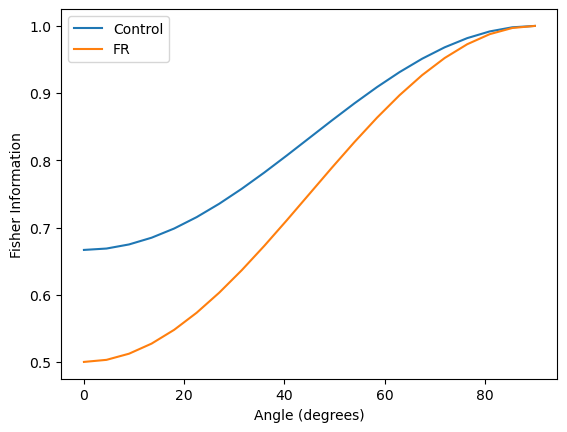

In [60]:
import numpy as np

def fisher(delta_mu, Sigma):
    # I = Δμ^T Σ^{-1} Δμ
    return float(delta_mu @ np.linalg.solve(Sigma, delta_mu))

def make_delta_mu(dim, angle, signal_strength=1.0):
    # 2D signal subspace embedded in higher-D
    v1 = np.zeros(dim); v1[0] = 1.0
    v2 = np.zeros(dim); v2[1] = 1.0
    d = np.cos(angle) * v1 + np.sin(angle) * v2
    return signal_strength * d

def make_cov(dim, shared_dir, shared_var, floor_var):
    # Σ = shared_var * u u^T + floor_var * I
    u = shared_dir / np.linalg.norm(shared_dir)
    return shared_var * np.outer(u, u) + floor_var * np.eye(dim)

def run():
    dim = 50
    shared_dir = np.zeros(dim); shared_dir[0] = 1.0  # shared noise aligned to v1
    
    
    ctr_var = 0.5                                # low-dim shared noise strength
    fr_var = 1
    # Condition A (control)
    floor_ctrl = 1
    floor_fr = 1
    
    Sigma_ctrl = make_cov(dim, shared_dir, ctr_var, floor_ctrl)

    # Condition B (FR): higher private noise floor (or lower gain)
    Sigma_fr = make_cov(dim, shared_dir, fr_var, floor_fr)
    # Sweep angle differences (small to large)
    angles = np.linspace(0, np.pi/2, 21)
    print("angle_deg  I_control  I_FR  ratio_FR/ctrl")
    I_CTR = []
    I_FR = []
    for ang in angles:
        dmu_ctr = make_delta_mu(dim, ang, signal_strength=1)
        dmu_fr = make_delta_mu(dim, ang, signal_strength=1)
        I_ctrl = fisher(dmu_ctr, Sigma_ctrl)
        I_fr = fisher(dmu_fr, Sigma_fr)
        print(f"{np.degrees(ang):8.2f}  {I_ctrl:8.3f}  {I_fr:6.3f}    {I_fr/I_ctrl:6.3f}")
        I_CTR.append(I_ctrl)
        I_FR.append(I_fr)
    plt.plot(np.degrees(angles), I_CTR, label='Control')
    plt.plot(np.degrees(angles), I_FR, label='FR')
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Fisher Information')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    run()


angle_deg  I_control  I_FR  ratio_FR/ctrl
    0.00     1.429   0.833     0.583
    4.50     1.451   0.859     0.592
    9.00     1.516   0.935     0.617
   13.50     1.623   1.060     0.653
   18.00     1.770   1.231     0.696
   22.50     1.952   1.444     0.740
   27.00     2.165   1.692     0.782
   31.50     2.404   1.971     0.820
   36.00     2.662   2.273     0.854
   40.50     2.935   2.591     0.883
   45.00     3.214   2.917     0.907
   49.50     3.494   3.243     0.928
   54.00     3.766   3.560     0.945
   58.50     4.025   3.862     0.960
   63.00     4.264   4.141     0.971
   67.50     4.477   4.390     0.981
   72.00     4.659   4.602     0.988
   76.50     4.805   4.773     0.993
   81.00     4.913   4.898     0.997
   85.50     4.978   4.974     0.999
   90.00     5.000   5.000     1.000


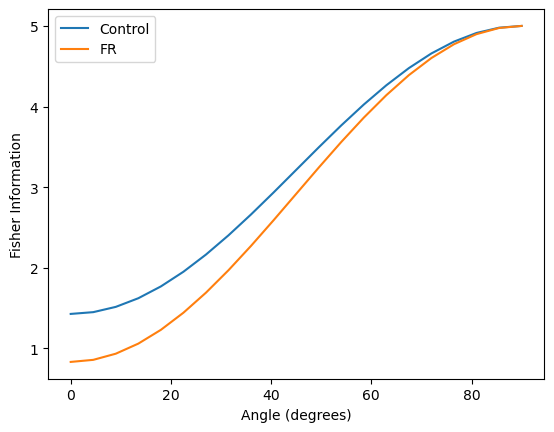

In [58]:
import numpy as np
import matplotlib.pyplot as plt

def fisher(delta_mu, Sigma):
    return float(delta_mu @ np.linalg.solve(Sigma, delta_mu))

def make_delta_mu(dim, angle, signal_strength=1.0):
    v1 = np.zeros(dim); v1[0] = 1.0
    v2 = np.zeros(dim); v2[1] = 1.0
    d = np.sin(angle) * v1 + np.cos(angle) * v2
    return signal_strength * d

def make_cov(dim, shared_dir, shared_var, floor_var):
    u = shared_dir / np.linalg.norm(shared_dir)
    return shared_var * np.outer(u, u) + floor_var * np.eye(dim)

def run():
    dim = 50

    # shared noise along e2 instead of e1  (THIS is the key change)
    shared_dir = np.zeros(dim); shared_dir[1] = 1.0

    ctr_var = 0.5
    fr_var  = 1.0
    floor_ctrl = .2
    floor_fr   = .2

    Sigma_ctrl = make_cov(dim, shared_dir, ctr_var, floor_ctrl)
    Sigma_fr   = make_cov(dim, shared_dir, fr_var,  floor_fr)

    angles = np.linspace(0, np.pi/2, 21)
    print("angle_deg  I_control  I_FR  ratio_FR/ctrl")

    I_CTR, I_FR = [], []
    for ang in angles:
        dmu = make_delta_mu(dim, ang, signal_strength=1.0)
        I_ctrl = fisher(dmu, Sigma_ctrl)
        I_fr   = fisher(dmu, Sigma_fr)
        print(f"{np.degrees(ang):8.2f}  {I_ctrl:8.3f}  {I_fr:6.3f}    {I_fr/I_ctrl:6.3f}")
        I_CTR.append(I_ctrl); I_FR.append(I_fr)

    plt.plot(np.degrees(angles), I_CTR, label="Control")
    plt.plot(np.degrees(angles), I_FR, label="FR")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Fisher Information")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    run()


angle(deg)  I_ctrl   I_FR   ratio
      0.0  11.111  11.111   1.000
     15.8  10.360  10.365   1.000
     29.2   8.677   8.692   1.002
     60.8   3.351   3.397   1.014
     90.0   0.917   0.978   1.066


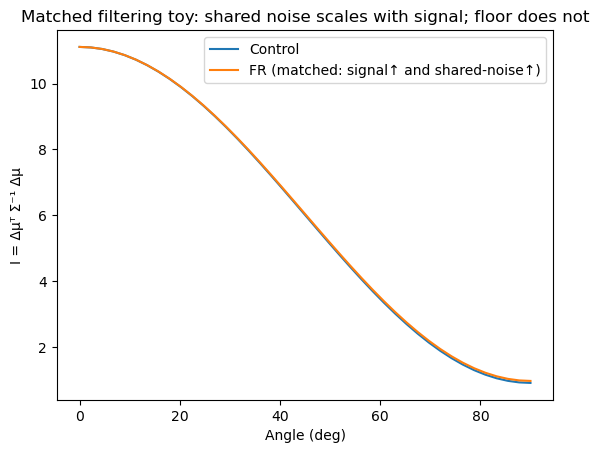

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def fisher(dmu, Sigma):
    return float(dmu @ np.linalg.solve(Sigma, dmu))

def unit(x):
    return x / np.linalg.norm(x)

def Sigma_matched(dim, u, a, sig_shared=1.0, sig_floor=0.3):
    """
    Shared noise enters through stimulus pathway u and is amplified by gain a:
      Σ = (a^2 * sig_shared^2) uu^T + (sig_floor^2) I
    """
    u = unit(u)
    return (a*a*sig_shared**2) * np.outer(u, u) + (sig_floor**2) * np.eye(dim)

def delta_mu_matched(dim, u, v, angle, a):
    """
    Signal difference is a mixture of:
      - stimulus-pathway component along u (scaled by a)
      - orthogonal component along v (not scaled)
    angle = 0  -> all in v (floor-limited)
    angle = 90 -> all in u (shared-pathway, matched)
    """
    u = unit(u); v = unit(v)
    return (np.sin(angle) * a) * u + (np.cos(angle) * 1.0) * v

def run():
    dim = 50
    u = np.eye(dim)[0]      # shared pathway direction
    v = np.eye(dim)[1]      # orthogonal direction

    sig_shared = 1.0
    sig_floor  = 0.3        # keep floor small so matched cancellation is visible

    a_ctrl = 1.0
    a_fr   = 2.0            # FR increases signal AND shared noise through same pathway

    angles = np.linspace(0, np.pi/2, 41)

    I_ctrl, I_fr = [], []
    for th in angles:
        dmu_c = delta_mu_matched(dim, u, v, th, a_ctrl)
        dmu_f = delta_mu_matched(dim, u, v, th, a_fr)

        Sig_c = Sigma_matched(dim, u, a_ctrl, sig_shared, sig_floor)
        Sig_f = Sigma_matched(dim, u, a_fr,   sig_shared, sig_floor)

        I_ctrl.append(fisher(dmu_c, Sig_c))
        I_fr.append(fisher(dmu_f, Sig_f))

    I_ctrl = np.array(I_ctrl)
    I_fr   = np.array(I_fr)

    print("angle(deg)  I_ctrl   I_FR   ratio")
    for deg in [0, 15, 30, 60, 90]:
        i = np.argmin(np.abs(np.degrees(angles) - deg))
        print(f"{np.degrees(angles[i]):9.1f}  {I_ctrl[i]:6.3f}  {I_fr[i]:6.3f}  {I_fr[i]/I_ctrl[i]:6.3f}")

    plt.plot(np.degrees(angles), I_ctrl, label="Control")
    plt.plot(np.degrees(angles), I_fr,   label="FR (matched: signal↑ and shared-noise↑)")
    plt.xlabel("Angle (deg)")
    plt.ylabel("I = Δμᵀ Σ⁻¹ Δμ")
    plt.title("Matched filtering toy: shared noise scales with signal; floor does not")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    run()


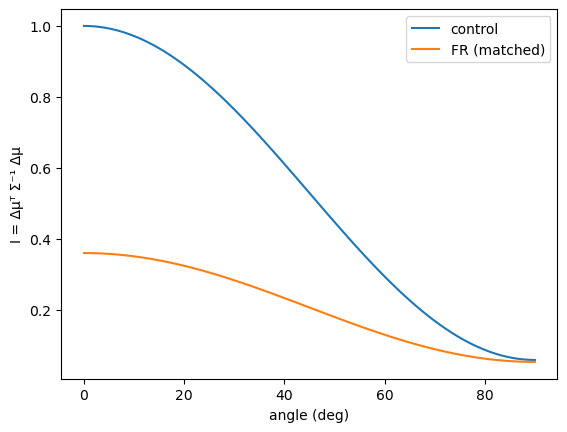

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def fisher(dmu, Sigma):
    return float(dmu @ np.linalg.solve(Sigma, dmu))

def Sigma(a, u, sig_shared=1.0, sig_floor=1.0):
    u = u / np.linalg.norm(u)
    return (a*a*sig_shared**2) * np.outer(u, u) + (sig_floor**2) * np.eye(len(u))

def run():
    D = 50
    u = np.eye(D)[0]          # shared pathway direction (mode 1)
    v = np.eye(D)[1]          # orthogonal direction (floor-only)

    sig_shared, sig_floor = 1.0, 1.0
    sig_shared, sig_floor = 4.0, 1.0
    a_ctrl, a_fr = 1.0, 0.6   # FR changes gain a (matched for signal + shared noise)

    ang = np.linspace(0, np.pi/2, 81)
    I_c, I_f = [], []

    for th in ang:
        d = np.cos(th)*u + np.sin(th)*v     # signal direction rotates with "distance"
        d = np.sin(th)*u + np.cos(th)*v
        I_c.append(fisher(a_ctrl*d, Sigma(a_ctrl, u, sig_shared, sig_floor)))
        I_f.append(fisher(a_fr  *d, Sigma(a_fr,   u, sig_shared, sig_floor)))

    plt.plot(np.degrees(ang), I_c, label="control")
    plt.plot(np.degrees(ang), I_f, label="FR (matched)")
    plt.xlabel("angle (deg)")
    plt.ylabel("I = Δμᵀ Σ⁻¹ Δμ")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    run()


Discriminability I = Δμᵀ Σ⁻¹ Δμ
  small Δ=0.30: control=0.084, FR=0.036
  large Δ=2.50: control=1.940, FR=1.210

Signal fraction in SHARED subspace (squared):
  small Δ=0.30: 0.083
  large Δ=2.50: 0.862

Top-mode contributions (control basis):
  small Δ, first few modes: [0.001 0.001 0.    0.    0.003 0.001 0.001 0.    0.    0.001 0.002 0.   ]
  small Δ (FR), first few: [0.001 0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.001 0.   ]
  large Δ, first few modes: [0.593 0.457 0.027 0.001 0.029 0.009 0.009 0.001 0.    0.012 0.018 0.   ]
  large Δ (FR), first few: [0.466 0.359 0.021 0.001 0.012 0.004 0.004 0.    0.    0.005 0.008 0.   ]


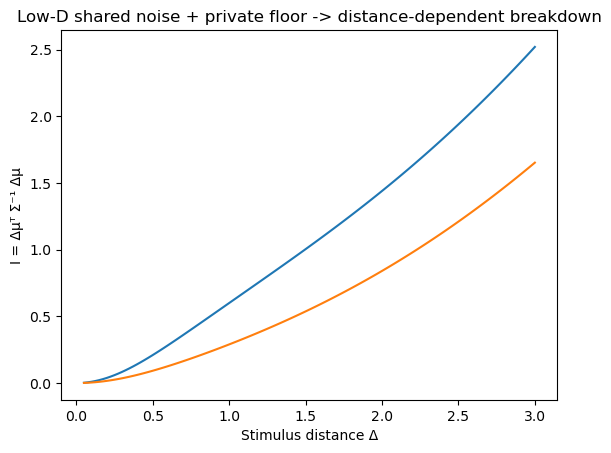

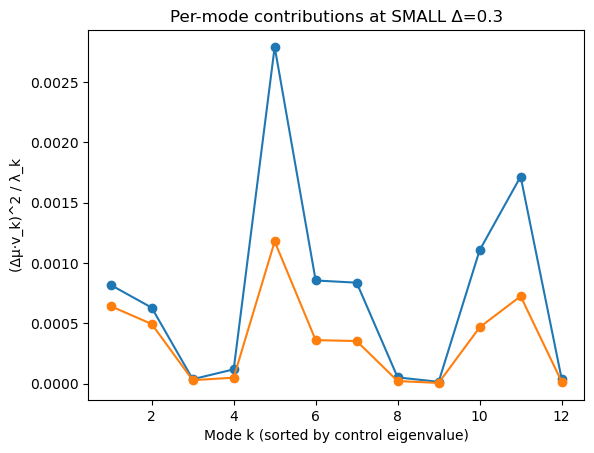

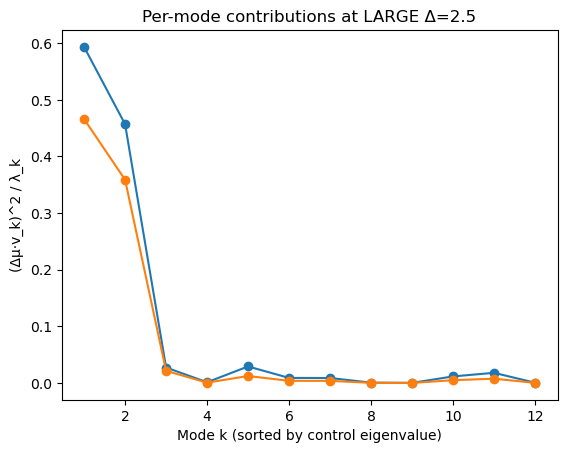

In [7]:
import numpy as np

# Optional plotting (comment out if you don't want matplotlib)
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

# ---- Model knobs ----
N = 80          # population dimension
r = 3           # rank of shared covariance (low-D)
sigma_shared = 2.0   # strength of shared variability
sigma_floor  = 1.0   # private noise floor (isotropic)

a_control = 1.0
a_FR      = 0.65
# Interpretation: "gain" a scales BOTH signal and shared noise (matched filtering).
# The private floor does NOT scale.

Delta0 = 1.0  # sets distance scale for signal rotating into the shared subspace

# ---- Build an orthonormal shared subspace U (N x r) ----
A = rng.normal(size=(N, r))
U, _ = np.linalg.qr(A)     # columns orthonormal
u_shared = U[:, 0]         # one shared direction

# Build a unit vector u_perp orthogonal to the shared subspace (lives in floor subspace)
x = rng.normal(size=N)
x = x - U @ (U.T @ x)
u_perp = x / np.linalg.norm(x)

def signal_dir(Delta):
    """
    Signal direction rotates with distance:
      small Delta -> mostly u_perp (floor subspace)
      large Delta -> mostly u_shared (shared subspace)
    """
    phi = np.arctan2(Delta, Delta0)  # 0 -> pi/2 as Delta increases
    v = np.cos(phi) * u_perp + np.sin(phi) * u_shared
    return v / np.linalg.norm(v)

def delta_mu(Delta, a_gain):
    """Mean difference vector."""
    amp = Delta  # signal magnitude grows with distance
    return a_gain * amp * signal_dir(Delta)

def Sigma(a_gain):
    """Covariance = low-D shared part (scaled) + isotropic floor (unscaled)."""
    shared = (a_gain**2) * (sigma_shared**2) * (U @ U.T)   # rank-r
    floor  = (sigma_floor**2) * np.eye(N)
    return shared + floor

def discrim_I(Delta, a_gain):
    """Mahalanobis distance: I = Δμᵀ Σ⁻¹ Δμ."""
    dmu = delta_mu(Delta, a_gain)
    S = Sigma(a_gain)
    return float(dmu.T @ np.linalg.solve(S, dmu))

def per_mode_contribs(Delta, a_gain, evecs, evals):
    """
    Mode contributions c_k = (Δμ·v_k)^2 / λ_k in a chosen eigenbasis (v_k, λ_k).
    """
    dmu = delta_mu(Delta, a_gain)
    proj = evecs.T @ dmu
    return (proj**2) / evals
def mode_contribs_in_control_basis(Delta, a_gain, evecs_control):
    """
    c_k = (Δμ·v_k)^2 / λ_k  using v_k from control, but λ_k from the condition's Σ.
    This isolates the matched-filtering idea cleanly.
    """
    dmu = delta_mu(Delta, a_gain)
    proj = evecs_control.T @ dmu

    S = Sigma(a_gain)
    # variance along each control eigenvector v_k: λ_k(cond) = v_k^T Σ_cond v_k
    lam_cond = np.sum(evecs_control * (S @ evecs_control), axis=0)

    return (proj**2) / lam_cond

# ---- Compute eigenmodes of CONTROL covariance (for interpretability) ----
S0 = Sigma(a_control)
evals0, evecs0 = np.linalg.eigh(S0)
idx = np.argsort(evals0)[::-1]   # descending
evals0 = evals0[idx]
evecs0 = evecs0[:, idx]

# ---- Look at small vs large distances ----
Delta_small = 0.3
Delta_large = 2.5

I_small_ctrl = discrim_I(Delta_small, a_control)
I_small_FR   = discrim_I(Delta_small, a_FR)
I_large_ctrl = discrim_I(Delta_large, a_control)
I_large_FR   = discrim_I(Delta_large, a_FR)

print("Discriminability I = Δμᵀ Σ⁻¹ Δμ")
print(f"  small Δ={Delta_small:0.2f}: control={I_small_ctrl:0.3f}, FR={I_small_FR:0.3f}")
print(f"  large Δ={Delta_large:0.2f}: control={I_large_ctrl:0.3f}, FR={I_large_FR:0.3f}")

def shared_fraction(Delta):
    v = signal_dir(Delta)
    return float(np.linalg.norm(U.T @ v)**2)  # squared fraction in shared subspace

print("\nSignal fraction in SHARED subspace (squared):")
print(f"  small Δ={Delta_small:0.2f}: {shared_fraction(Delta_small):0.3f}")
print(f"  large Δ={Delta_large:0.2f}: {shared_fraction(Delta_large):0.3f}")

# ---- Per-mode contributions (first K modes) ----
K = 12
# c_small_ctrl = per_mode_contribs(Delta_small, a_control, evecs0, evals0)
# c_small_FR   = per_mode_contribs(Delta_small, a_FR,      evecs0, evals0)  # basis fixed to control
# c_large_ctrl = per_mode_contribs(Delta_large, a_control, evecs0, evals0)
# c_large_FR   = per_mode_contribs(Delta_large, a_FR,      evecs0, evals0)


c_small_ctrl = mode_contribs_in_control_basis(Delta_small, a_control, evecs0)
c_small_FR   = mode_contribs_in_control_basis(Delta_small, a_FR,      evecs0)
c_large_ctrl = mode_contribs_in_control_basis(Delta_large, a_control, evecs0)
c_large_FR   = mode_contribs_in_control_basis(Delta_large, a_FR,      evecs0)

print("\nTop-mode contributions (control basis):")
print("  small Δ, first few modes:", np.round(c_small_ctrl[:K], 3))
print("  small Δ (FR), first few:", np.round(c_small_FR[:K], 3))
print("  large Δ, first few modes:", np.round(c_large_ctrl[:K], 3))
print("  large Δ (FR), first few:", np.round(c_large_FR[:K], 3))

# ---- Optional plots ----
Deltas = np.linspace(0.05, 3.0, 120)
I_ctrl = np.array([discrim_I(d, a_control) for d in Deltas])
I_fr   = np.array([discrim_I(d, a_FR)      for d in Deltas])

plt.figure()
plt.plot(Deltas, I_ctrl)
plt.plot(Deltas, I_fr)
plt.xlabel("Stimulus distance Δ")
plt.ylabel("I = Δμᵀ Σ⁻¹ Δμ")
plt.title("Low-D shared noise + private floor -> distance-dependent breakdown")
plt.show()

plt.figure()
plt.plot(np.arange(1, K+1), c_small_ctrl[:K], marker="o")
plt.plot(np.arange(1, K+1), c_small_FR[:K], marker="o")
plt.xlabel("Mode k (sorted by control eigenvalue)")
plt.ylabel("(Δμ·v_k)^2 / λ_k")
plt.title(f"Per-mode contributions at SMALL Δ={Delta_small}")
plt.show()

plt.figure()
plt.plot(np.arange(1, K+1), c_large_ctrl[:K], marker="o")
plt.plot(np.arange(1, K+1), c_large_FR[:K], marker="o")
plt.xlabel("Mode k (sorted by control eigenvalue)")
plt.ylabel("(Δμ·v_k)^2 / λ_k")
plt.title(f"Per-mode contributions at LARGE Δ={Delta_large}")
plt.show()
